Epochs: 50000
Batch size: 128
----------- Epoch 0 -----------
0 [D loss: 0.823396, acc.: 12.89%] [G loss: 0.423784]


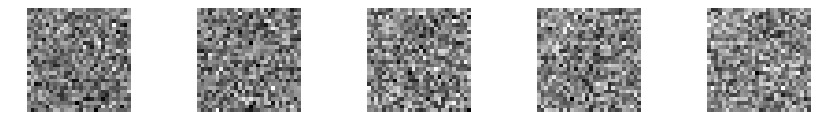

----------- Epoch 10000 -----------
10000 [D loss: 0.026028, acc.: 98.83%] [G loss: 7.362655]


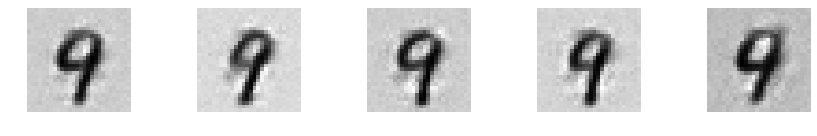

----------- Epoch 20000 -----------
20000 [D loss: 0.265400, acc.: 93.36%] [G loss: 18.086922]


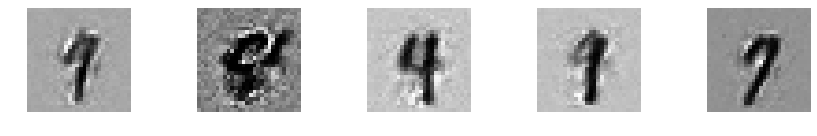

----------- Epoch 30000 -----------
30000 [D loss: 0.137902, acc.: 96.88%] [G loss: 12.313124]


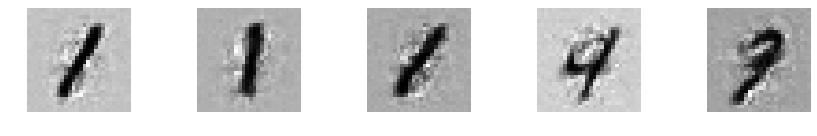

----------- Epoch 40000 -----------
40000 [D loss: 0.110221, acc.: 95.31%] [G loss: 9.815957]


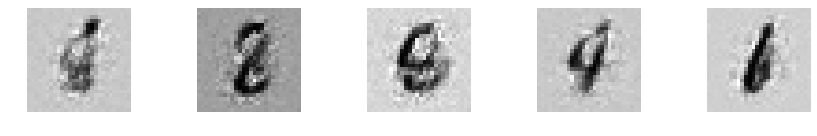

----------- Epoch 49999 -----------
49999 [D loss: 0.126410, acc.: 96.09%] [G loss: 11.825514]


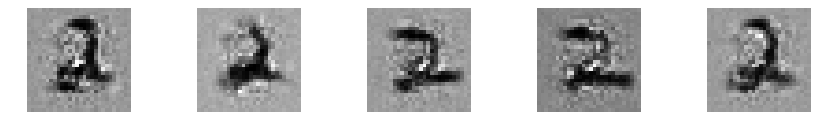

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Flatten, Reshape


class GAN(object):
    def __init__(self):
        self.z_dim = 100
        self.width = 28
        self.height = 28
        self.channels = 1
        self.img_shape = (self.width, self.height, self.channels)
        self.adam = Adam(lr=0.002, beta_1=0.5)
        
        self.generator = self.Build_Generator()
        self.generator.compile(loss = 'binary_crossentropy', optimizer = self.adam, metrics = ['accuracy'])
        
        self.discriminator = self.Build_Discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', optimizer = self.adam, metrics = ['accuracy'])
        self.discriminator.trainable = False
        
        inputs = Input(shape = (self.z_dim,))
        hidden = self.generator(inputs)
        output = self.discriminator(hidden)
        self.combined = keras.Model(inputs, output)
        self.combined.compile(loss = 'binary_crossentropy', optimizer = self.adam)
        
        
    def Build_Generator(self):
        model = keras.Sequential(
        [
            Dense(256, input_dim=self.z_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dense(512),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dense(1024),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dense(np.prod(self.img_shape), activation='tanh'),
            Reshape(self.img_shape)
        ])
        
        return model
    
    
    def Build_Discriminator(self):
        model = keras.Sequential(
        [
            Flatten(input_shape=self.img_shape),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dense(256),
            LeakyReLU(alpha=0.2),
            Dense(1, activation='sigmoid')
        ])
        
        return model
    
    
    def Plot_Generated(self, n_ex = 5, dim = (1, 5), figsize = (12, 2)):
        noise = np.random.normal(0, 1, size = (n_ex, self.z_dim))
        generated_images = self.generator.predict(noise)
        generated_images = generated_images.reshape(generated_images.shape[0], self.width, self.height)
        plt.figure(figsize = figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generated_images[i, :, :], interpolation = 'nearest', cmap = 'gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        
    def Train(self, epochs = 50000, plt_frq = 10000, batch_size = 128):
        (train_x, _), (_, _) = keras.datasets.mnist.load_data()

        train_x = train_x.reshape(60000, self.width, self.height, self.channels)
        train_x = train_x.astype('float32')/255
        
        print('Epochs:', epochs)
        print('Batch size:', batch_size)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, train_x.shape[0], batch_size)
            imgs = train_x[idx]

            noise = np.random.normal(0, 1, (batch_size, self.z_dim))
            gen_imgs = self.generator.predict(noise)

            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False
            g_loss = self.combined.train_on_batch(noise, valid)

            if epoch%plt_frq == 0 or epoch == epochs - 1:
                print('-----------', 'Epoch %d' % epoch, '-----------')
                print('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.Plot_Generated()
                
    def Save_Model(self):
        self.generator.save('generator_model.h5')
        self.discriminator.save('discriminator_model.h5')
        self.combined.save('combined_model.h5')

                
if __name__ == '__main__':
    gan = GAN()
    gan.Train()
    gan.Save_Model()
    

W0828 06:55:54.519203 139814858405760 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


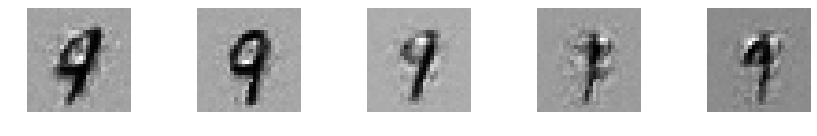

In [0]:
import numpy as np
from tensorflow.keras import models

G = models.load_model('generator_model.h5')

width = 28
height = 28
z_dim = 100


def Plot_Generated(n_ex = 5, dim = (1, 5), figsize = (12, 2)):
    noise = np.random.normal(0, 1, size = (n_ex, z_dim))
    generated_images = G.predict(noise)
    generated_images = generated_images.reshape(generated_images.shape[0], width, height)
    plt.figure(figsize = figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :], interpolation = 'nearest', cmap = 'gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
Plot_Generated()

